In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from joblib import load
from aqosd_experiments.config import *
from aqosd_experiments.data import *
from aqosd_experiments.utils import *
from aqosd_experiments.plot import *
from aqosd_experiments.scorers import *

In [3]:
def plot_osdm(osdms):
    colors = iter(['k', 'r', 'b', 'darkorange', 'g'])
    markers = iter([',', ',', ',', ',', ','])
    results = osdms.get_results()
    best = results[len(osdms.k_metric_idx_)]['cost']
    k1 = map(lambda x: 'test_{}'.format(x), [s for s in list(SCORING.keys())])
    fig, ax = plt.subplots(figsize=(3, 2))
    ax2 = ax.twinx()
    k_metric = sorted(results.keys())
    costs = [results[k]['cost'] for k in k_metric]
    lns = []
    ax2.set_ylabel('Coverage Error', color='b')
    ax2.tick_params(axis='y', colors='b')
    ax.set_ylabel('Precision, Sens., Spec., Acc.')
    plt.setp(ax.get_yticklabels(), color="b")
    metric_min, metric_max = len(results[k_metric[0]]['metric_idx']), len(results[k_metric[-1]]['metric_idx'])
    ax.set_yticks(range(metric_min, metric_max + 1), range(metric_min, metric_max + 1))
    ax.set_xlabel("Metrics total cost")
    for score in k1:
        avg = [results[k]['cv_scores'][score] for k in k_metric]
        upper = [results[k]['cv_scores'][score] + results[k]['cv_scores'][score + '_std'] for k in k_metric]
        lower = [results[k]['cv_scores'][score] - results[k]['cv_scores'][score + '_std'] for k in k_metric]
        l = score.replace('test_', '').capitalize()
        if 'cov' not in score:
            c = next(colors)
            lns += ax.plot(costs, avg, marker=next(markers), markersize=3, color=c, label=l)
            ax.fill_between(costs, upper, lower, alpha=0.2, color=c, lw=1)
            min_max_mcc = min(avg), max(avg)
        else:
            c = next(colors)
            lns += ax2.plot(costs, avg, marker=next(markers), markersize=3, color=c, label=l)
            ax2.fill_between(costs, upper, lower, color=c, alpha=0.2, lw=1)
            min_max_acc = min(avg), max(avg)
    ax.axvline(best, color='#f0027f')
    for a in (ax, ax2):
        [item.set_fontsize(8) for item in
         ([a.title, a.xaxis.label, a.yaxis.label] + a.get_xticklabels() + a.get_yticklabels())]
    labs = [lab.get_label() for lab in lns]
    ax.legend(lns, labs, loc=8, ncol=1)
    ax.set_xlim(min(costs) - 1, max(costs) + 1)
    plt.grid(False)
    plt.tight_layout()
    return fig, pd.DataFrame.from_dict(results).T

In [4]:
metrics, bottlenecks = import_and_prepare_data(RAW_DATASET_PATH,  HOST_LIST)
print('Shape of metrics : ',metrics.shape,'\t','Shape of bottlenecks : ',bottlenecks.shape)
print('Label cardinality = %.5f \t Label density = %.5f' % (bottlenecks.sum(axis=1).mean(),bottlenecks.mean(axis=1).mean()))
metric_names, bottleneck_names = list(metrics.columns), list(bottlenecks.columns)
print(metric_names)
print(100*'-')
print(bottleneck_names)

0 days 23:59:50 of Data
Shape of metrics :  (8640, 104) 	 Shape of bottlenecks :  (8640, 32)
Label cardinality = 1.96019 	 Label density = 0.06126
['SRV./: Free inodes in %', 'SRV./: Space utilization', 'SRV./: Used space', 'SRV./boot: Free inodes in %', 'SRV./boot: Space utilization', 'SRV./boot: Used space', 'SRV.Available memory', 'SRV.Available memory in %', 'SRV.CPU idle time', 'SRV.CPU iowait time', 'SRV.CPU softirq time', 'SRV.CPU system time', 'SRV.CPU user time', 'SRV.CPU utilization', 'SRV.Context switches per second', 'SRV.Free swap space', 'SRV.Free swap space in %', 'SRV.Interface enp0s8: Bits received', 'SRV.Interface enp0s8: Bits sent', 'SRV.Interrupts per second', 'SRV.Load average (15m avg)', 'SRV.Load average (1m avg)', 'SRV.Load average (5m avg)', 'SRV.Memory utilization', 'SRV.Number of processes', 'SRV.Number of running processes', 'GW1./: Free inodes in %', 'GW1./: Space utilization', 'GW1./: Used space', 'GW1./boot: Free inodes in %', 'GW1./boot: Space utilizatio

In [5]:
sss= [s.replace('SRV.','') for s in metric_names if 'SRV.' in s]
sss

['/: Free inodes in %',
 '/: Space utilization',
 '/: Used space',
 '/boot: Free inodes in %',
 '/boot: Space utilization',
 '/boot: Used space',
 'Available memory',
 'Available memory in %',
 'CPU idle time',
 'CPU iowait time',
 'CPU softirq time',
 'CPU system time',
 'CPU user time',
 'CPU utilization',
 'Context switches per second',
 'Free swap space',
 'Free swap space in %',
 'Interface enp0s8: Bits received',
 'Interface enp0s8: Bits sent',
 'Interrupts per second',
 'Load average (15m avg)',
 'Load average (1m avg)',
 'Load average (5m avg)',
 'Memory utilization',
 'Number of processes',
 'Number of running processes']

In [6]:
n_metric_SRV = sum(1 for s in metric_names if 'SRV.' in s)
n_metric_GW1 = sum(1 for s in metric_names if 'GW1.' in s)
n_metric_GW11 = sum(1 for s in metric_names if 'GW11.' in s)
n_metric_GW111 = sum(1 for s in metric_names if 'GW111.' in s)
print("n_metric : { SRV : ",n_metric_SRV,", GW1 : ",n_metric_GW1, ", GW11 : ",n_metric_GW11,", GW111 : ",n_metric_GW111,"}")
SRV_costs= 0.5 * np.ones(n_metric_SRV)
GW1_costs= 1.0 * np.ones(n_metric_GW1)
GW11_costs= 1.5 * np.ones(n_metric_GW11)
GW111_costs= 2.0 * np.ones(n_metric_GW111)          
overheads=np.concatenate([SRV_costs, GW1_costs, GW11_costs, GW111_costs])
print(sum(overheads)/4)

n_metric : { SRV :  26 , GW1 :  26 , GW11 :  26 , GW111 :  26 }
32.5


In [7]:
def get_x_names(results):
        sn='metric_idx'
        k_metric = sorted(results.keys())
        x_names = {}
        for k in k_metric:
            if k == 1:
                x_names[k] = ["+" + str(s) for s in set(results[k][sn])]
            else:
                x_names[k] = []
                plus = set(results[k][sn]) - set(results[k - 1][sn])
                moins = set(results[k - 1][sn]) - set(results[k][sn])
                if moins:
                    x_names[k] += sorted(["-" + str(s) for s in moins])
                if plus:
                    x_names[k] += sorted(["+" + str(s) for s in plus])
        return [', '.join(x_names[k]) for k in x_names]

0.8469807409650526
0.8385179517194575
0.8303516205644244


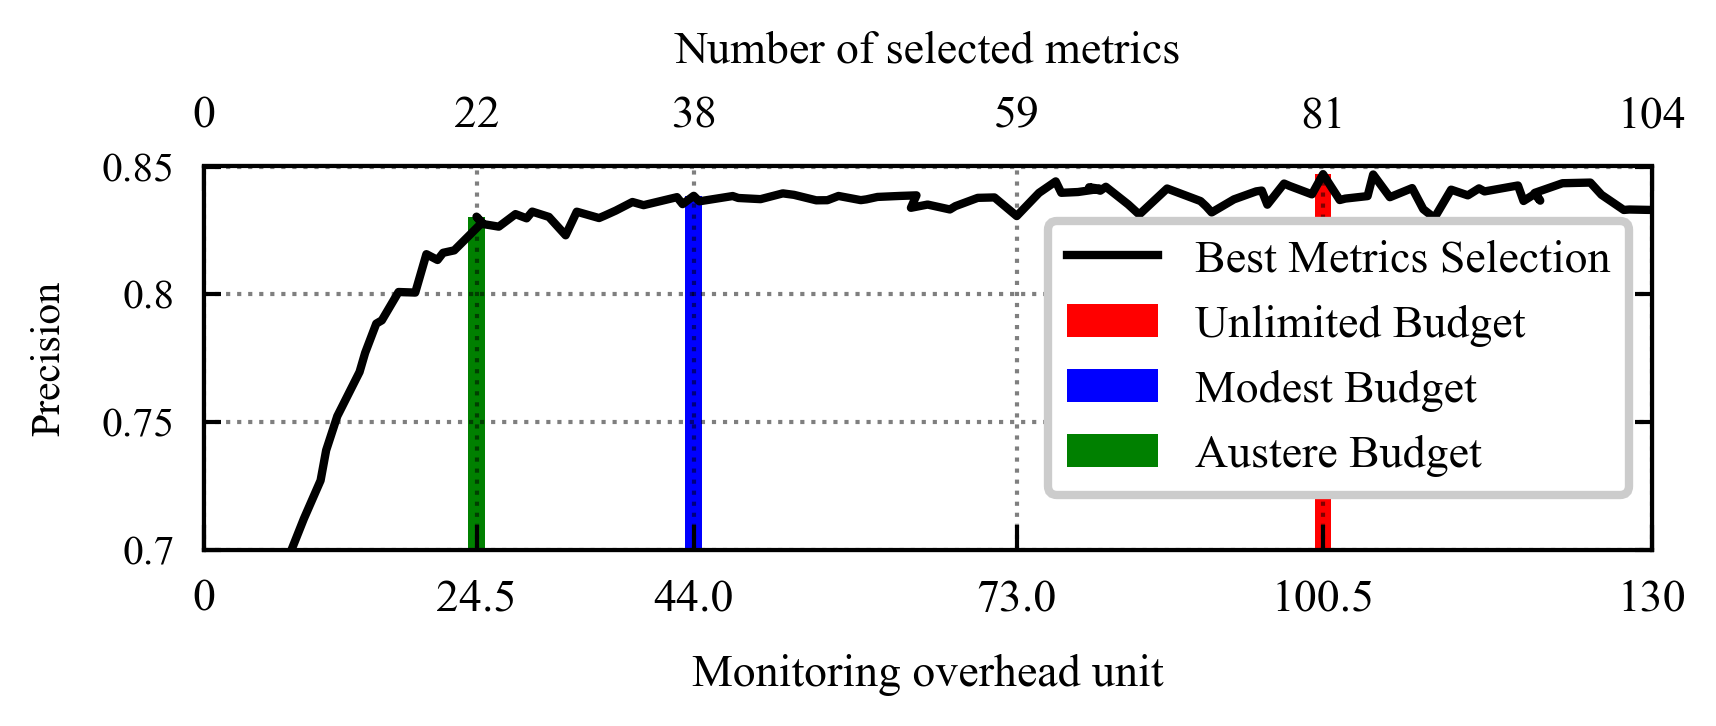

In [8]:
def plot_osdm(odsm):
    def get_xtick(list_1, list_2):
        list_1.append(max(list_2))
        list_1.append(min(list_2))
        list_1.sort()
        list_2.sort()
        ok=False
        while (ok==False):
            for i in range(1,len(list_1)):
                if list_1[i]-list_1[i-1]>31.5:
                    list_1.insert(i,(list_1[i]+list_1[i-1])/2)
            if i==len(list_1)-1:
                ok=True
                break
        new_list = list_1[:]
        for i, v in enumerate(list_1):
            ok = [abs(v-k) for j, k in enumerate(list_2)]
            ind = ok.index(min(ok))
            new_list[i] = list_2[ind]
        return new_list
    colors = ('k', 'r', 'b', 'g')
    figs, scores, ticks, = [], [], []
    ll = ('Best Metrics Selection', 'Unlimited Budget','Modest Budget','Austere Budget')
    k1 = map(lambda x: 'test_{}'.format(x), ['precision'])
    results = odsm.get_results()
    best = results[len(odsm.k_metric_idx_)]['cost']
    x_names = get_x_names(results)
    overhead_budgets = [1000, best, best/2, best/4]
    #overhead_budgets=[np.sum(overheads),np.sum(overheads)/2,np.sum(overheads)/4]
    for score in k1:
        f, ax = plt.subplots(figsize=(3, 1.35))
        for j, b in enumerate(overhead_budgets):
            k_metric = [k for k in sorted(results.keys()) if results[k]['cost'] <= b]
            costs = [results[k]['cost'] for k in k_metric]
            avg = [results[k]['cv_scores'][score] for k in k_metric]
            if j==0:
                costs.insert(0, 0), avg.insert(0, 0)
                costs.append(130), avg.append(avg[-2])
                ax.plot(costs, avg, color=colors[j], label=ll[j], ls= '-')
                c_all=costs
                c_k_metric=k_metric
            else :
                bestx , besty= costs[np.argmax(avg)], avg[np.argmax(avg)]
                ax.bar(bestx, besty, color=colors[j],  label=ll[j], width=1.5)
                ticks.append(bestx)
                print(besty)
        ticks = get_xtick(ticks, c_all)
        ax.set_xticks(ticks), ax.xaxis.set_ticklabels(ticks, rotation = 0, fontsize=5.5)
        ax.set_xlim(min(ticks), max(ticks))
        ax.set_ylim(.7,.85)
        ax.set_yticks([0.7,.75,.8,.85]), ax.yaxis.set_ticklabels([0.7,.75,.8,.85], rotation = 0, fontsize=5.5)
        s = score.replace('test_', '').capitalize()
        ax.set_ylabel(s)
        [item.set_fontsize(5) for item in ([ax.title,ax.yaxis.label]+ax.get_yticklabels())]
        ax.legend(loc=7, ncol=1, fontsize=5.5)
        ax.set_zorder(2)
        ax.tick_params(axis='y', which='major', size=2)
        ax.tick_params(axis='x', which='minor', size=0)
        ax.set_xlabel("Monitoring overhead unit", fontsize=5.5)
        ax2=ax.twiny()
        ax2.set_zorder(1)
        #print([k for k in c_k_metric if results[k]['cost'] in ticks])# [50, 19, 11]
        ax2.set_xticks(ticks), ax2.xaxis.set_ticklabels([0, 22, 38, 59, 81, 104], rotation = 0, fontsize=5.5)
        ax2.tick_params(axis='x', which='minor', size=0)#, ax2.tick_params(axis='x', which='both',direction ='out')
        ax2.set_xlabel("Number of selected metrics", fontsize=5.5)
        ax2.patch.set_visible(False), ax2.grid(False)
        plt.minorticks_off()
        plt.tight_layout()
        figs.append(f), scores.append(s)
    return figs,scores
odsm= load(MODELS_PATH + 'scn_1OSDMS.joblib')
figs, scores = plot_osdm(odsm)
_= [f.savefig(FIG_PATH +'all_'+ score+"_metric_selection.pdf", bbox_inches='tight')for f, score in zip(figs, scores)]

[1000, 100.5, 50.25, 25.125]


,All Metrics,Unlimited Budget,Modest Budget,Austere Budget
Precision,0.833153,0.846981,0.838518,0.830352


,All Metrics,Unlimited Budget,Modest Budget,Austere Budget
Subset accuracy,0.653241,0.660648,0.646296,0.64213


,All Metrics,Unlimited Budget,Modest Budget,Austere Budget
Coverage error,9.854167,9.381481,9.577315,9.658333


,All Metrics,Unlimited Budget,Modest Budget,Austere Budget
Sensitivity,0.819122,0.83476,0.846188,0.842052


,All Metrics,Unlimited Budget,Modest Budget,Austere Budget
Specificity,0.98957,0.99039,0.989586,0.988748


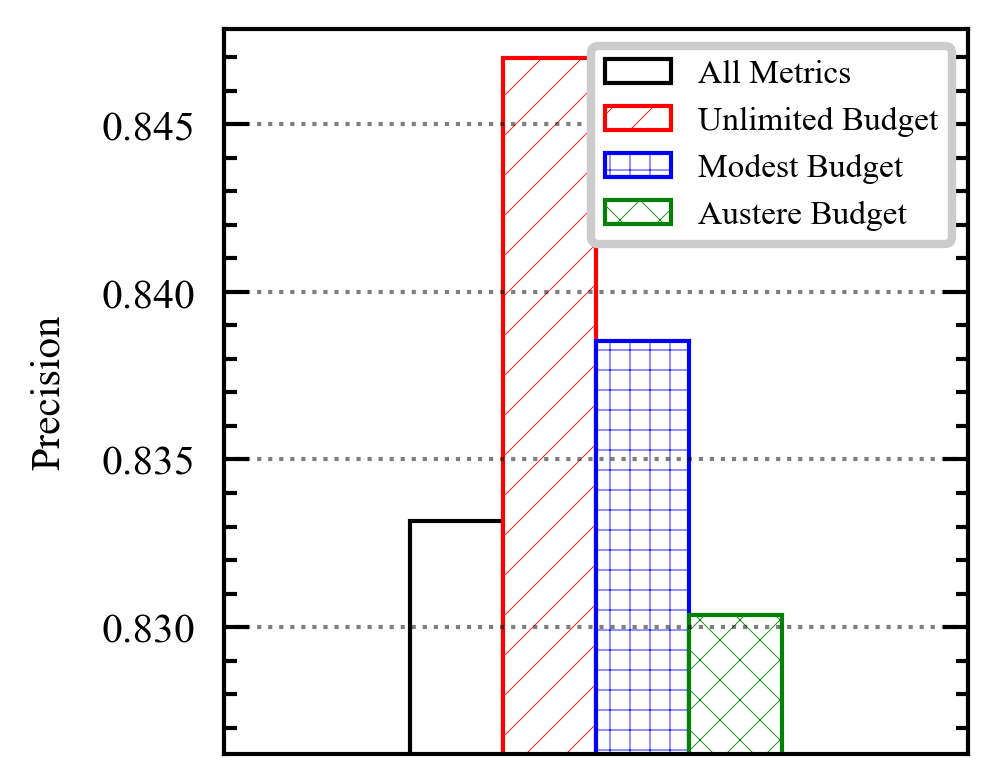

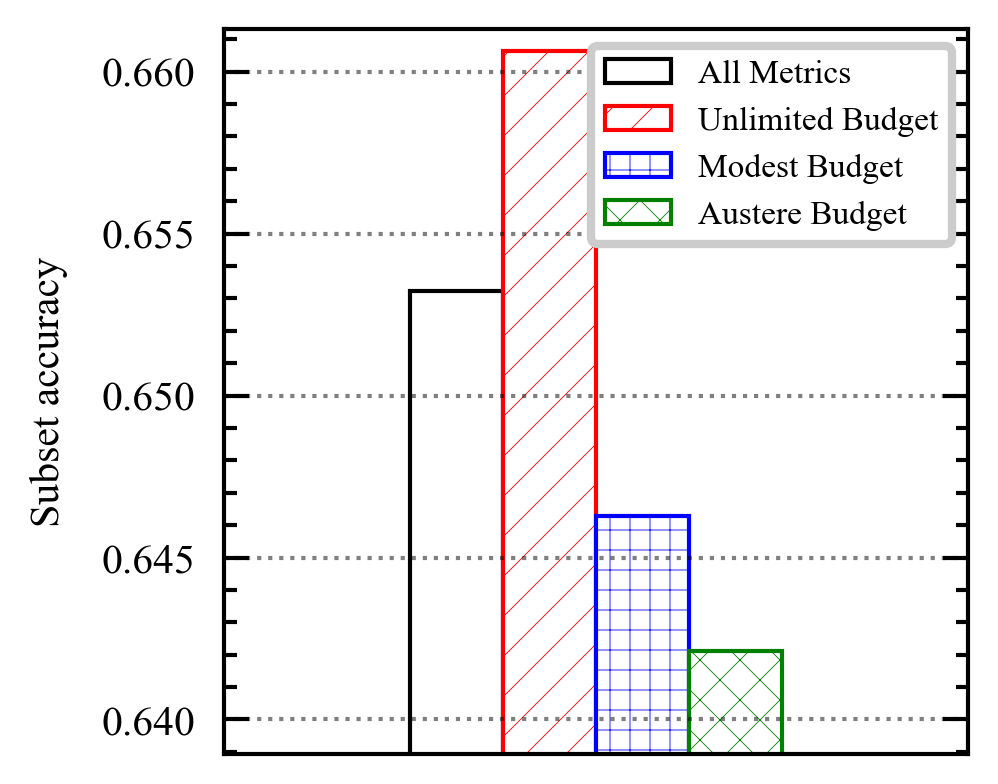

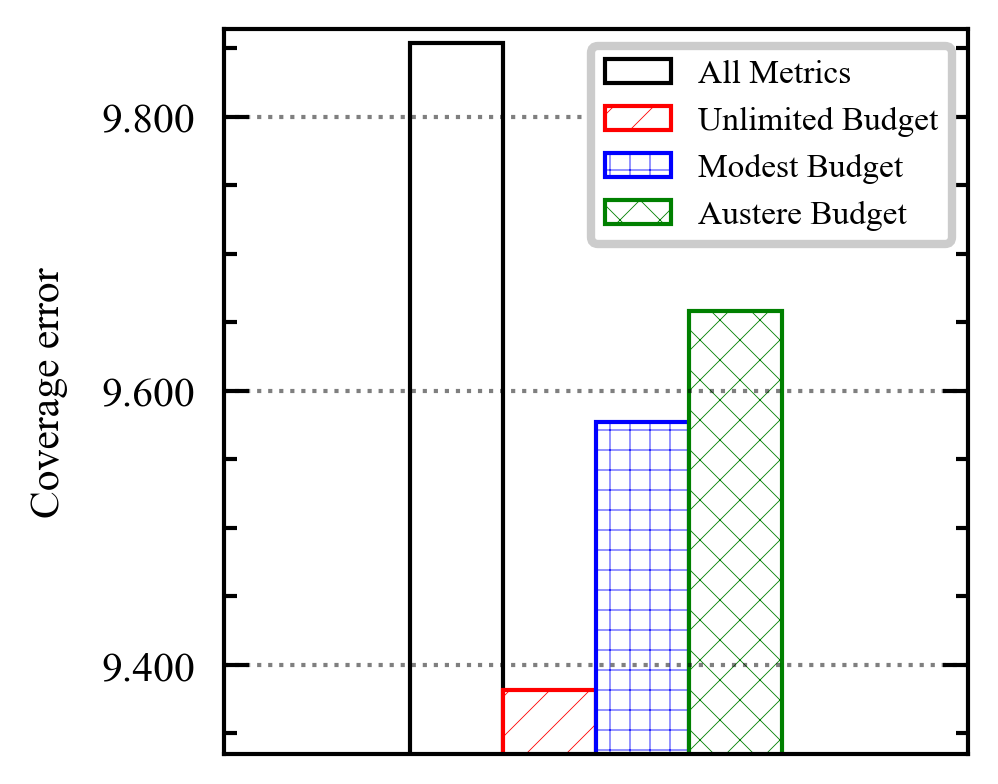

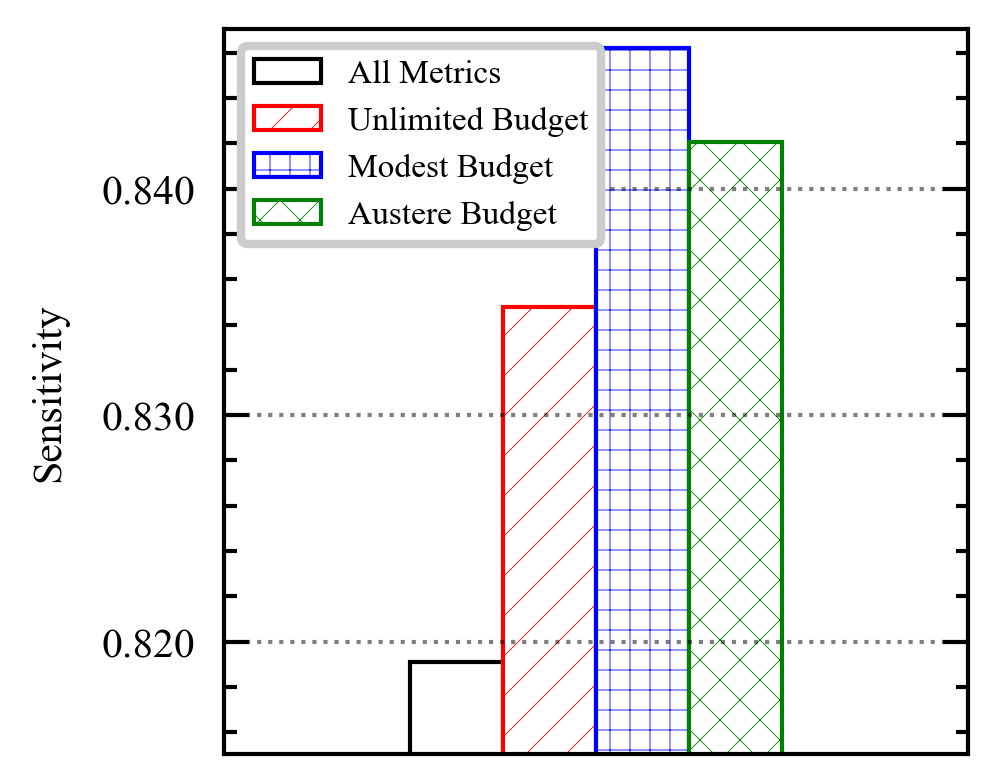

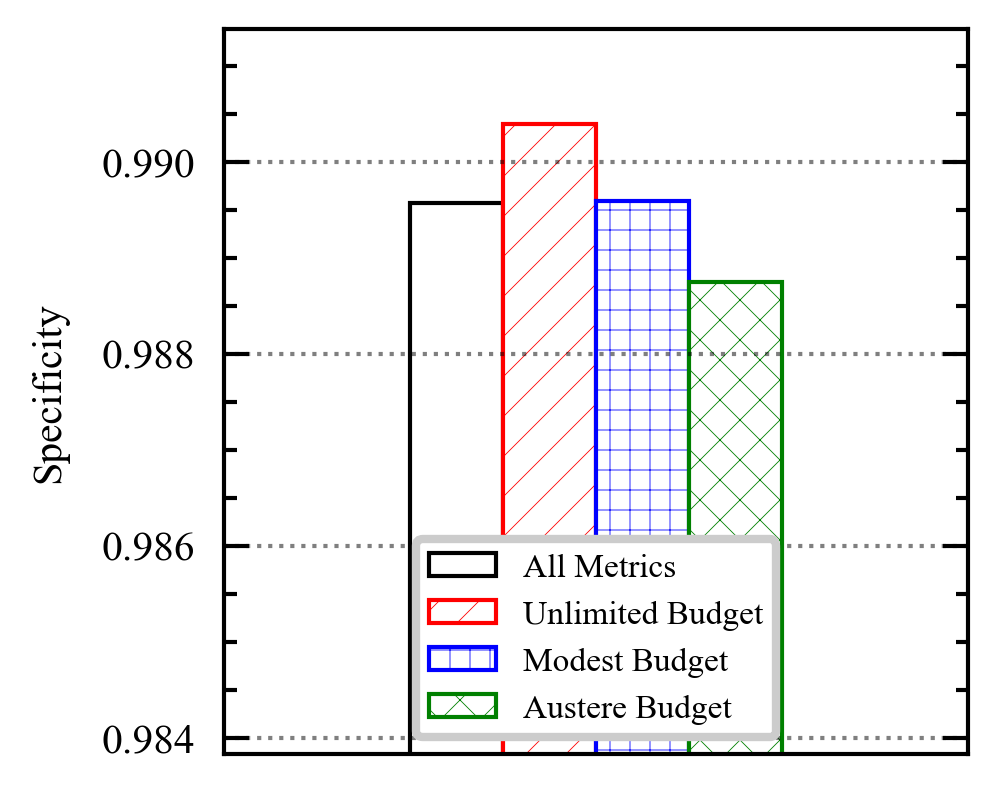

In [9]:
from itertools import cycle
h=5
mpl.rcParams['hatch.linewidth'] = 0.1 
hatchs=("",h*"/", h*"+",h*"x")
c = cycle(['k', 'r', 'b', 'g'])
def plot_osdm(odsm):
    scores = ['precision','subset accuracy', 'coverage error','sensitivity', 'specificity']
    k1 = map(lambda x: 'test_{}'.format(x), scores)
    figs = []
    results = odsm.get_results()
    best = results[len(odsm.k_metric_idx_)]['cost']
    overhead_budgets=[1000, best,best/2,best/4]
    print(overhead_budgets)
    bestys = []
    for j, b in enumerate(overhead_budgets):        
        k_metric = [k for k in sorted(results.keys())  if results[k]['cost'] <= b]
        costs = [results[k]['cost'] for k in k_metric]
        avg = [results[k]['cv_scores']['test_precision'] for k in k_metric]
        bestys.append(np.argmax(avg))
    locs={'precision':1,'subset accuracy':1, 'coverage error':1,'sensitivity':2, 'specificity' :8}
    for score in k1:
        f, ax = plt.subplots(figsize=(1.6, 1.6))
        df, ss = {}, []
        for j , b in enumerate(overhead_budgets):    
            if b !=1000:
                k_metric = [k for k in sorted(results.keys())  if results[k]['cost'] <= b]
                costs = [results[k]['cost'] for k in k_metric]
                avg = [results[k]['cv_scores'][score] for k in k_metric]
                besty = avg[bestys[j]]
            else:
                besty = results[len(results.keys())]['cv_scores'][score]
            ss.append(besty)
        y_lab=score.replace('test_', '').capitalize()
        df[y_lab] = ss
        df = pd.DataFrame(df, index=['All Metrics','Unlimited Budget','Modest Budget','Austere Budget']).T
        df.plot.bar(ax=ax, color='w', lw=.5, rot=0,legend=False)
        display(df)
        [[(patch.set_hatch(hatch),  patch.set_edgecolor(next(c))) for patch in container.patches] for container, hatch in zip(ax.containers, hatchs)]
        ax.set_ylim(df.min(axis=1)[0]/1.005, df.max(axis=1)[0]*1.001)
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
        ax.set_ylabel(y_lab)
        ax.legend(loc=locs[y_lab.lower()], ncol=1, fontsize=4), ax.set_xticks([]), ax.xaxis.set_ticklabels([])
        [item.set_fontsize(5) for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels())]
        figs.append(f)
    return figs, scores

odsm= load(MODELS_PATH + 'scn_1OSDMS.joblib')
figs, scores = plot_osdm(odsm)
_ = [f.savefig(FIG_PATH +score+"_metric_selection.pdf", bbox_inches='tight') for f, score in zip(figs, scores)]